In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [4]:
# Carregue o DataFrame com colunas de latitude e longitude 
data = pd.read_csv('./dados_tratados/dados_completos_escolas.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_da_escola            120 non-null    int64  
 1   nome_da_escola          120 non-null    object 
 2   tipo_da_escola          120 non-null    object 
 3   logradouro              120 non-null    object 
 4   numero                  120 non-null    object 
 5   bairro                  120 non-null    object 
 6   subprefeitura           120 non-null    object 
 7   latitude                120 non-null    float64
 8   longitude               120 non-null    float64
 9   quantidade_de_material  120 non-null    int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 9.5+ KB


In [11]:

# Crie uma matriz de distâncias entre todas as escolas
coords = data[['latitude', 'longitude']].to_numpy()
dist_matrix = squareform(pdist(coords, metric='euclidean'))

# Crie um gerenciador de pesquisa
manager = pywrapcp.RoutingIndexManager(len(data), 1, 0)

# Crie um problema de roteamento
routing = pywrapcp.RoutingModel(manager)

# Crie e registre uma função objetivo (minimizar a distância)
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return dist_matrix[from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Configure os parâmetros de busca
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Resolva o problema de roteamento
solution = routing.SolveWithParameters(search_parameters)

# Extraia a rota otimizada
route = []
index = routing.Start(0)
while not routing.IsEnd(index):
    node = manager.IndexToNode(index)
    route.append(node)
    index = solution.Value(routing.NextVar(index))

# Adicione o ponto de partida (escola 0) ao início e fim da rota
route.append(route[0])

# Atualize o DataFrame com a ordem de entrega
data['ordem_entrega'] = route[1:]

# Ordene o DataFrame com base na ordem de entrega
data.sort_values(by='ordem_entrega', inplace=True)
data.reset_index(drop=True, inplace=True)

# Calcula a distância total da rota otimizada
best_distance = sum(dist_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

print("Rota otimizada:", route)
print("Distância total da rota otimizada:", best_distance)

# O DataFrame agora contém a ordem de entrega atualizada

Rota otimizada: [0, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Distância total da rota otimizada: 6.209711830360935


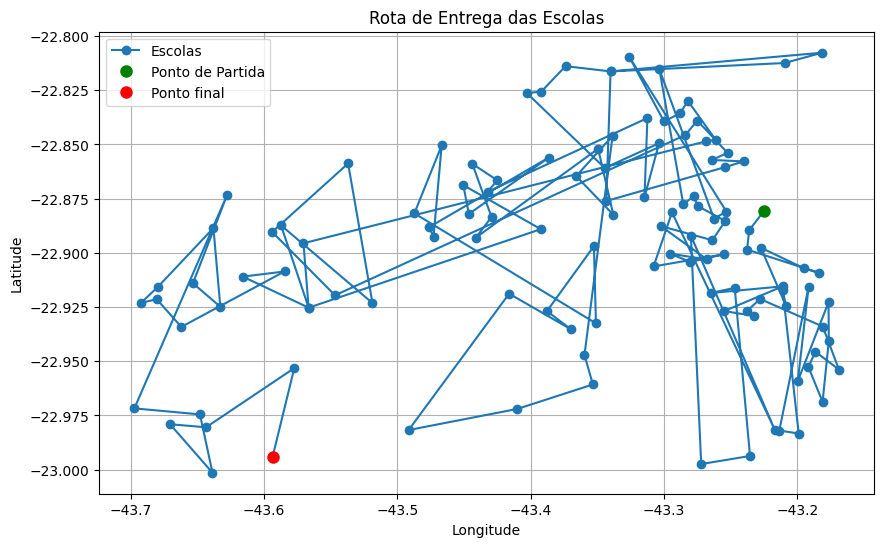

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(data['longitude'], data['latitude'], marker='o', label='Escolas', linestyle='-')
plt.plot(data['longitude'][0], data['latitude'][0], marker='o', markersize=8, label='Ponto de Partida', linestyle='None', color='green')
plt.plot(data['longitude'][119], data['latitude'][119], marker='o', markersize=8, label='Ponto final', linestyle='None', color='red')
plt.title('Rota de Entrega das Escolas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()